# Introduction to Bagging

-----


In this IPython Notebook, we introduce the concept of [_bagging_][wbag], which is shorthand for bootstrap aggregation, where random samples of the data are used to construct multiple decision trees. Since each tree only sees part of the data, each tree is less accurate than if it had been constructed over the full data set. Thus, each tree is known as a _weak learner_. A more powerful, meta-estimator is subsequently constructed by averaging over these many weak learners. The approach of constructing weak learners, and combining them into a more powerful estimator is at the heart of several, very powerful machine learning techniques, including the [random forest][wrf] and [extremely randomized trees][wert].

In this notebook, we first introduce the formalism behind bagging, including a discussion of the concept of bootstrapping. Next, we move on to a discussion of the random forest algorithm, which will include its application to both classification and regression tasks. We also will look at the application of a random forest to multiple-output regression problems, where a regressor is used to predict multiple target features. Finally, we look into a second type of bagging meta-estimator, extremely randomized trees, and see how they compare to a random forest.

-----
[rfsk]: http://scikit-learn.org/stable/modules/ensemble.html#forest
[wert]: https://en.wikipedia.org/wiki/Random_forest#ExtraTrees
[wbag]: https://en.wikipedia.org/wiki/Bootstrap_aggregating
[wrf]: https://en.wikipedia.org/wiki/Random_forest

## Table of Contents

[Formalism](#Formalism)

- [Bootstrap](#Bootstrap)
- [Random Forest](#Random-Forest)
- [Extremely Randomized Trees](#Extremely-Randomized-Trees)

[Random Forest: Classification](#Random-Forest:-Classification)

- [Classification: Iris Data](#Classification:-Iris-Data)
- [Random Forest: Decision Surface](#Random-Forest:-Decision-Surface)
- [Random Forest: Hyperparameters](#Random-Forest:-Hyperparameters)
- [Random Forest: Feature Importance](#Random-Forest:-Feature-Importance)
- [Classification: Adult Data](#Classification:-Adult-Data)

[Random Forest: Regression](#Random-Forest:-Regression)

- [Regression: Auto MPG Data](#Auto-MPG-Data)
- [Regression: Multi-Output](#Regression:-Multi-Output)

[Extremely Randomized Trees](#Extremely-Randomized-Trees)

-----

Before proceeding with the _Formalism_ section of this Notebook, we first have our standard notebook setup code.

-----

In [1]:
# Set up Notebook
% matplotlib inline

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings('ignore')

sns.set_style('white')

-----

[[Back to TOC]](#Table-of-Contents)

## Formalism

One of the simplest machine learning algorithms to understand is the [decision tree][wdt]. Often, a decision tree is made as large as possible to provide the best predictive model, as this produces a high purity in the leaf nodes. Doing so, however, can lead to overfitting where the model predicts very accurately on the training data but fails to generalize to the test data; and where the accuracy is, as a result, much lower. 

A simple approach to overcoming the overfitting problem is to train many decision trees on a subset of the data and to average the resulting predictions. This process is known as bootstrap aggregation, which is often shortened to bagging. Of these two terms, aggregation is simple to understand, one simply aggregates (or, in particular, averages) the predictions of the many trees. 

The term bootstrap is a statistical term that defines how a sample can be constructed from an original data set. Given a data set, there are two simple ways to construct a new sample. As a specific example, consider building a list of shows you wish to watch from an online provider like Netflix or Amazon by placing them in  virtual cart. In the first approach, you take a show of the virtual shelf and place it in your cart. This is known as sampling without replacement since the show is only present in your cart. In the second approach, you take a show and place it in your cart, but there remains a copy of the show on the virtual shelf. This is known as sampling with replacement, since we replace the original instance.

Sampling with replacement has several advantages that make it important for machine learning. First, we can construct many large samples from our original data set, where each sample is not limited by the size of the original data set. For example, if our original data set contained 100 entries, sampling without replacement would mean we could only create ten new samples that each had ten entries. On the other hand, sampling with replacement means we could create 100 (or more) new samples that each have ten (or more) entries.

Building many samples from a parent population allows us to build an estimator on each sample and average (or aggregate) the results. This is demonstrated in the following figure, where an original data set is used to train a number of decision trees. In this case, each tree is constructed from a bootstrap sample of the original data set. The predictions from these trees are aggregated at the end to make a final prediction.

![Decision Trees Image made by Professor Robert J. Brunner](images/dt-rjb-2.png)

The scikit learn library provides a bagging meta-estimator, that can generate bootstrap samples, apply a standard estimator (including other algorithms beyond a decision tree), and aggregate the resulting predictions. This technique can be used for classification tasks ([`BaggingClassifier`][skbc]) or for regression ([`BaggingRegressor`][skbr])

These estimators have several hyperparameters that control their performance:
- `base_estimator`: The estimator to use on each sample, by default this is a decision tree.
- `n_estimators`: The number of base estimators to create for the ensemble, by default this is ten.
- `max_samples` : The number of instances to draw from the parent population to train each base estimator, by default this is one.
- `max_features`: The number of features to draw from the  parent population to train each base estimator, by default this is one.

This bagging estimator allows different basic algorithms, beyond the decision tree, to be used for ensemble learning. For the rest of the notebook, however, we will focus on two specific ensemble techniques that efficiently implement bagging by using decision trees: the random forest and extremely randomized trees.

Beyond improved prediction, bagging algorithms provide an additional benefit. Since each tree (or other learning algorithm in the case of a _Bagging_ estimator) is constructed from a subsample of the original data, the performance of that tree can be tested on the data from the original data that were not used in its construction. These data are known as _out-of_bag_ data, and provide a useful metric for the performance of each individual tree used in the ensemble. 

Before introducing the random forest, we first explore the construction and use of bootstrap samples.

-----
[skbc]:http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html
[skbr]: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html

[[Back to TOC]](#Table-of-Contents)

### Bootstrap

Formally, a bootstrap refers to any statistical process that relies on the generation of random samples with replacement. To demonstrate the benefit of the bootstrap, we will bootstrap the `size` feature from the _tips_ data set, which is the number of patrons served by the restaurant for a meal. The first Code cell below loads the tips data and randomly samples five instances, showing the `size` feature for each.

-----




In [2]:
# Load Data Set
tdf = sns.load_dataset('tips')

# Display several random 'size' features
tdf['size'].sample(5)

182    3
65     3
28     2
55     2
222    1
Name: size, dtype: int64

-----

Before proceeding with the computation of a statistical metric, the next Code cell extract this feature as a NumPy array, and displays the number of instances, which is 244. We also compute the mean and standard deviation of this population. These values will be compared to the same metrics computed from the samples we will generate.

-----

In [3]:
# Extract size feature as an array
sizes = tdf['size'].as_matrix()

# Display number of instances
print(f'Number of instances = {sizes.shape[0]}')

# Compute and display population statistics
print(f'Mean (population) = {np.mean(sizes):5.3f}')
print(f'Standard deviation (population) = {np.std(sizes):5.3f}')

Number of instances = 244
Mean (population) = 2.570
Standard deviation (population) = 0.949


-----

We can now generate a random sample, with replacement from these data. In the following Code cell, we create a NumPy `RandomState` to ensure reproducibility of our results, and define our initial sample size as 50. This value can be changed, and since we are using replacement, can actually be larger than the size of the parent population (although this is generally not a good idea). Finally, we employ the NumPy `choice` method to sample `sample_size` instances with replacement, which is indicated by passing the parameter `replace=True`. 

The output is a NumPy array that is randomly sampled with replacement from the parent array, `sizes`. Note, if we pass the parameter `replace=False` we produce a sample without replacement, which can be useful in other contexts.

-----

In [4]:
# Define random seed for reproducability
rng = np.random.RandomState(23)

# Define sample size
sample_size = 50

# Generate sample with replacement
rng.choice(sizes, sample_size, replace=True)

array([2, 4, 3, 2, 3, 2, 4, 2, 4, 2, 3, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4,
       2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 5, 3, 6, 3, 3, 3, 4, 2, 2, 3, 2, 4,
       3, 2, 4, 2])

-----

We can use the `choice` method to create a bootstrap sample, which can be used to generate an estimate for our original parent population (i.e., the `sizes` array). To do this, we generate one random sample with replacement, and compute the mean and standard deviation. For this one sample, our mean and standard deviation are remarkably close to those we computed from the parent population.

-----

In [5]:
# generate sample
sample = rng.choice(sizes, sample_size, replace=True)

# Compute and display sample statistics
print(f'Mean (one sample) = {np.mean(sample):5.3f}')
print(f'Standard deviation (one sample) = {np.std(sample):5.3f}')

Mean (one sample) = 2.620
Standard deviation (one sample) = 0.978


-----

The initial power of the bootstrap results from our ability to extend the creation of this one sample to many. In the following Code cell, we generate 1000 samples with replacement from our parent population, and fill a NumPy array of shape 1000 rows and 50 columns, with these samples. From these new samples, we calculate the sample statistics. In this case, both the mean and standard deviation are almost exactly the same as those from the parent population.

-----

In [6]:
num_samples = 1000

the_sample = np.zeros((num_samples, sample_size))

for idx in range(num_samples):
    the_sample[idx] = rng.choice(sizes, sample_size, replace=True)

print(the_sample.shape)
# Compute and display sample statistics
print(f'Mean ({num_samples} samples) = {np.mean(the_sample):5.3f}')
print(f'Standard deviation ({num_samples} samples) = {np.std(the_sample):5.3f}')

(1000, 50)
Mean (1000 samples) = 2.571
Standard deviation (1000 samples) = 0.950


-----

Of course, we do not need to compute these statistics across the entire sample, we can compute the mean for each sample, creating an array of means. In this case, we can consider each sample mean to be an estimate of the mean of the parent population. We can average these means (i.e., aggregate) these sample means to provide an estimate of the population mean, along with a measure of the uncertainty in this estimate, by computing the standard deviation of our sample means. 

The following Code cell performs this calculation, by first creating a new NumPy array that contains the means of each sample. Next, the mean and standard deviation of these samples is computed and displayed. Once again the mean is nearly identical to the mean value of our parent population, but the uncertainty on this estimate is remarkably low (and could be made smaller by using more samples.

This simple example has demonstrated how bootstrap aggregation, in this case of the sample means, can provide a powerful estimator of a population statistic. In each case, we generate multiple samples with replacement, and compute a statistics across these samples, and aggregate the result at the end. This concept underlies all bagging estimators.

-----

In [7]:
the_means = np.mean(the_sample, axis=1)

# Compute and display sample statistics
print(f'Mean ({num_samples} samples) = {np.mean(the_means):5.3f}')
print(f'Standard deviation ({num_samples} samples) = {np.std(the_means):5.3f}')

Mean (1000 samples) = 2.571
Standard deviation (1000 samples) = 0.131


-----

<font color='red' size = '5'> Student Exercise </font>

The previous Code cell demonstrated how to generate samples with replacement, an to compute the mean across those sample. Go back through the previous Code cells and change this to sampling without replacement. How do the statistical measures change? Does this make sense?


-----

[[Back to TOC]](#Table-of-Contents)

### Random Forest

A [random forest][wrf] employs bagging to create a set of decision trees from a given data set. Each tree is constructed from a bootstrap sample, and the final prediction is generated by aggregating the predictions of the individual trees, just like the previous code example demonstrated by using the mean of the sample means to estimate the mean of the parent population. However, the random forest introduces one additional random concept into the tree construction. 

Normally, when deciding on a split point during the construction of a decision tree, all features are evaluated and the one that has the highest impurity (or produces the largest information gain) is selected as the feature on which to split along with the value at which to split that feature. In a random forest, a random subset of all features are used to make the split choice, and the best feature on which to split is selected form this subset. 

This extra randomness produces individual decision trees that are less sensitive to small scale fluctuations, which is known as under-fitting. As a result, each newly created decision tree is a weak learner since they are not constructed from all available information. Yet, since each decision tree is constructed from different sets of features, by aggregating their predictions, the final random forest prediction is improved and less affected by overfitting.

Each tree in the random forest is constructed from a different combination of features. As a result, we can use the _out-of-bag_ performance from each tree to rank the importance of the features used to construct the trees in the forest. This allows for robust estimates of feature importance to be computed after constructing a random forest, which can provide useful insight into the nature of a training data set.

-----

[wrf]: https://en.wikipedia.org/wiki/Random_forest



[[Back to TOC]](#Table-of-Contents)

### Extremely Randomized Trees

The [extremely randomized tree][wert] algorithm, or _extra trees_, extends the random forest by introducing yet another form of randomness. In this case, the algorithm proceeds in the same manner as in the construction of a tree in a random forest by selecting a random subset of features when determining on which feature to split each node. The extra trees algorithm, however, does not select the best threshold on which to split automatically. Instead, the extra trees computes a set of random thresholds and selects the best split value from this random set. 

This algorithm can produce trees that are, individually, even weaker on their own in making a prediction. However, by aggregating their predictions, the extra randomness can produce robust predictions that are less sensitive to overfitting.

-----

[wert]: https://en.wikipedia.org/wiki/Random_forest#ExtraTrees

[[Back to TOC]](#Table-of-Contents)

## Random Forest: Classification

Having completed the discussion on bootstrap aggregation, and introduced the random forest algorithm, we can now transition to putting this powerful ensemble algorithm to work. The scikit learn library provides a robust implementation of the [random forest] algorithm. This implementation includes the _Bagging estimator's_ hyperparameters that were previously listed, however the default values are in some cases different. The two most important hyperparameters for a random forest are
- `n_estimators`, which is the number of decision trees that will be constructed to build the forest, the default value is ten, and 
- `max_features`, which is the number of features to examine when choosing the best split feature and value. By default this is `auto`, which means the number of features to examine will be set to the square root of the total number of features. Other values can be an integer number of features, a floating point percentage of the total number of features (e.g., 25% of all features randomly selected), the square root of the total number of features, and the base two logarithm of the total number of features.


To demonstrate using a random forest with the scikit-learn library, we will first load in the Iris data. With these data, we will construct a simple random forest to demonstrate _feature importance_. Next, we will look at the decision surface for this random forest as applied to the Iris data. After this, we will explore the effect of changing hyperparameters by using multiple decision surfaces. Finally, we will switch to a larger data set to see the impact of a random forest on generating predictions from a more complex data set.

----
[skdtc]: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

-----

[[Back to TOC]](#Table-of-Contents)

### Classification:  Iris Data

We can now apply the Random Forest algorithm to the Iris data to create a classification model. The basic approach is simple, and follows the standard scikit-learn estimator philosophy:

1. Import our estimator, [`RandomForestClassifier`][skrfc], from the proper scikit-learn module, `ensemble`.
2. Create the estimator and specify the appropriate hyperparameters. For a random forest, we can accept the defaults, or specify values for specific hyperparameters such as `n_estimators` or `max_features`.
3. Fit the model to the training data, note that by using our simple `get_iris_data` helper function we have loaded the Iris data, split the data into training and testing sets, and scaled all data by first normalizing the training data. Although this last step is not required for tree-based ensemble classifiers.
4. Predict new classes with our trained model (or in the simple demonstration below, generate a performance metric via the `score` method).

These steps are demonstrated in the following code cell, where obtain our data, and show the distribution of instances in a two-dimensional scatter plot, create our estimator, fit the estimator to our training data, and generate a performance score on the testing data. 

-----
[skdtc]: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

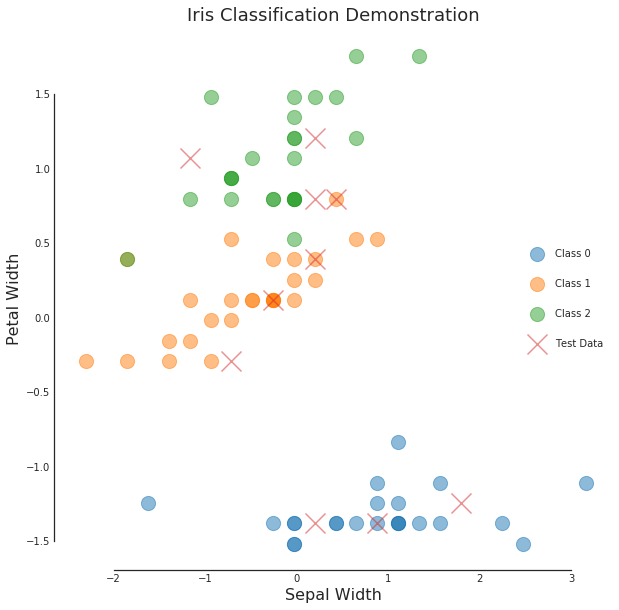

In [8]:
from helper_code import iris as hi

# Amount to hold out for 'blind' testing
test_frac = 0.5

# Show the 'Train' and 'Test' data plot.
show_plot = True

# Split data into training and testing
# Note that we have both 'data' and 'labels'
d_train_sc, d_test_sc, l_train, l_test = \
    hi.get_iris_data(test_frac, show_plot)

In [9]:
# Next lets try Decision Trees
from sklearn.ensemble import RandomForestClassifier

# Lets build our model and train it all at once
rfc = RandomForestClassifier(n_estimators=10, max_features='auto',
                             min_samples_split=2, random_state=0)

# Fit estimator to scaled training data
rfc = rfc.fit(d_train_sc, l_train)

# Compute and display accuracy score
score = 100.0 * rfc.score(d_test_sc, l_test)
print(f"Random Forest prediction accuracy = {score:5.1f}%")

Random Forest prediction accuracy =  94.7%


-----

Notice that, even when using only 50% of the total data for training, our random forest classifier still achieves remarkable accuracy on the testing data. For completeness, we also display the classification report and the confusion matrix in the following two Code cells. The per-class precision and recall are very good, with a minor issue in the prediction of class `Virginica` and `Versicolor`, which is also demonstrated clearly in the confusion matrix.

-----

In [10]:
from sklearn.metrics import classification_report

# Thre types of Iris in data set
labels = ['Setosa', 'Versicolor', 'Virginica']

# Predict on test data and report scores
y_pred = rfc.predict(d_test_sc)
print(classification_report(l_test, y_pred, \
                            target_names = labels))

             precision    recall  f1-score   support

     Setosa       1.00      1.00      1.00        27
 Versicolor       0.95      0.87      0.91        23
  Virginica       0.89      0.96      0.92        25

avg / total       0.95      0.95      0.95        75



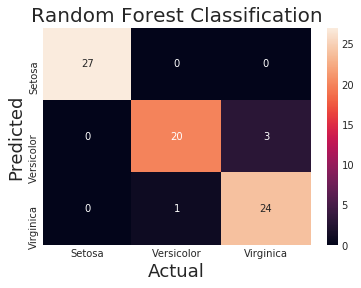

In [11]:
from helper_code import mlplots as ml

# Call confusion matrix plotting routine
ml.confusion(l_test.reshape(l_test.shape[0]), 
             y_pred, labels, 3, 
             'Random Forest Classification')

-----

[[Back to TOC]](#Table-of-Contents)

### Random Forest:  Feature Importance

As the previous example demonstrated, the random forest is easy to use and often provides impressive results. In addition, by its very nature, a random forest provides an implicit measure of the importance of the individual features in generating the final predictions. While an individual decision tree provides this information, the random forest provides an aggregated result, that is generally more insightful and less sensitive to fluctuations in the training data that might bias the importance values determined by a decision tree. In the calculation of feature importance from a random forest, higher values indicate a more important feature. 

We demonstrate how to extract the feature importance for a random forest classifier in the following Code cell, where we see that for this training data set only two features: Petal Width and Petal Length, account for most of the importance. However, unlike for the decision tree example, the other two features have non-negligible importance.

----

In [12]:
# Display feature importance as computed from the random forest

# Feature names
feature_names = ['Sepal Length', 'Sepal Width', 
                 'Petal Length', 'Petal Width']

# Display name and importance
for name, val in zip(feature_names, rfc.feature_importances_):
    print(f'{name} importance = {100.0*val:5.2f}%')

Sepal Length importance = 10.23%
Sepal Width importance =  5.20%
Petal Length importance = 41.74%
Petal Width importance = 42.83%


-----

[[Back to TOC]](#Table-of-Contents)

### Random Forest:  Decision Surface

To better understand how a classification algorithm performs on a given data set, and to compare multiple classifiers, we can train a classifier and use this estimator to predict values on a grid of values. In this case, we can see how the algorithm would classify data that span a particular combination of feature values. This visualization, in two dimensions, is known as a decision surface since we are seeing how decisions would be made. 

We demonstrate constructing a decision surface in the following Code cell by using several helper methods. First, we need to reduce our data set down to two dimensions to make the decision surface visualization. This step is accomplished by the `trim_data` helper function, which takes our training features and labels and returns a two dimensional array that holds two features: Sepal Width and Petal Width, along with the classification. Next, we generate a two-dimensional mesh grid along these two dimensions. 

We apply a random forest tree to the trimmed two-dimensional data (we could fit on the full data, but in this example we use only the two dimensions used in the plot), and apply to the mesh grid to construct the decision surface. Finally, we generate a scatter plot of the training data and color the underlying mesh appropriately by the predicted class for that cell.

As the decision surface below demonstrates, this default random forest separates the classes cleanly with linear cuts (which, combined together, produce non-linear classification boundaries) . On the other hand, even though each split generates a linear classification, their combination can be non-linear (note the rectangle cut-out enclosing the single instance of _versicolor_).

-----

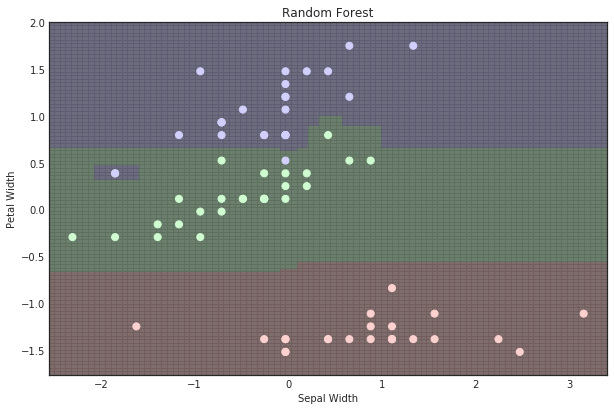

In [13]:
# Make a two-dimensional Iris data set
n_data = hi.trim_data(d_train_sc, l_train)

# Construct mesh grid data
mdata = hi.get_mdata(n_data)

fig, ax = plt.subplots(figsize=(10,8))

# Now train our model
rfc.fit(n_data[:,:2], n_data[:,2])
    
# Predict for mesh grid
z = rfc.predict(mdata)
    
# Plot training data and mesh grid
hi.splot_data(ax, n_data, mdata, z,
              'Sepal Width', 'Petal Width', 50)
    
ax.set_title(f'Random Forest') ;

-----

[[Back to TOC]](#Table-of-Contents)

### Random Forest: Hyperparameters

Earlier in this notebook, we presented a partial list of the hyperparameters that are available to use with the [RandomForestClassifier][skrfc] were presented, the full set is available from the estimator's online documentation. Of these hyperparameters, the effect of some are easier to understand, such as the `n_estimators`, which controls how many decision trees are constructed to make the random forest. To fully understand the impact of a hyperparameter, beyond simply computing the performance metrics for different values, we can construct and compare decisions surfaces for different values of a particular hyperparameter.

In the following Code call, we generate three different decision surfaces, corresponding to three different values of the `n_estimators` hyperparameter: 5, 10, and 15. As the following figures demonstrate, the first decision surface is rather simple, and captures most of the test data. The second decision surface is more complex, and the final figure is even more complex. Note that in this case the decision tree is only splitting on these two features. 

----

[skdtc]: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

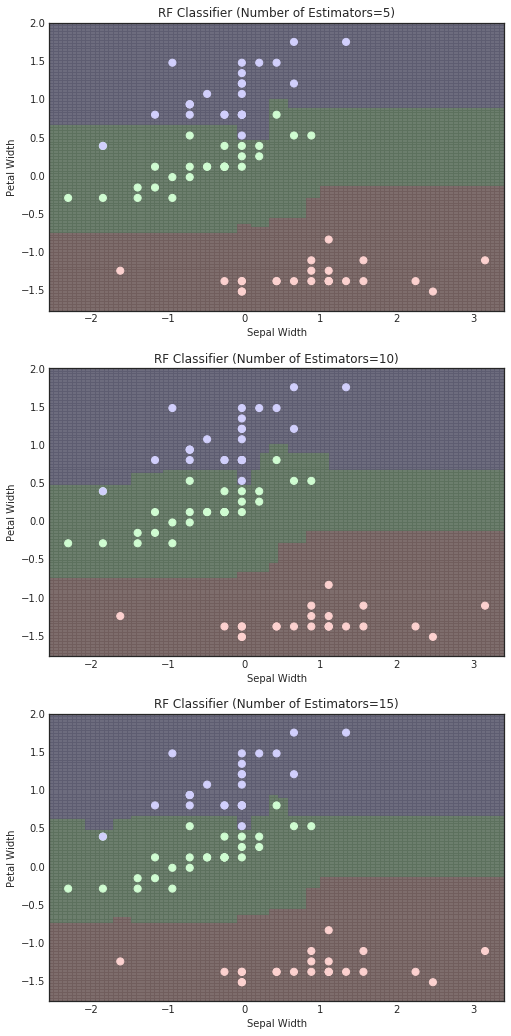

In [14]:
# List of our hyperparameter values
num_estimators = [5, 10, 15]

# Show the mesh grid and training data

fig, axs = plt.subplots(figsize=(10,6 * len(num_estimators)), 
                        nrows=len(num_estimators), ncols=1, 
                        sharex=False)

# Iterate through different neighbor counts
for idx, num in enumerate(num_estimators):
    
    # Now set model hyperparameter
    rfc.set_params(n_estimators=num, random_state=23)
    
    # Now train our model
    rfc.fit(n_data[:,:2], n_data[:,2])
    
    # Predict for mesh grid
    z = rfc.predict(mdata)
    
    # Plot training data and mesh grid
    hi.splot_data(axs[idx], n_data, mdata, z, 
                  'Sepal Width', 'Petal Width', 50)
    
    axs[idx].set_title(f'RF Classifier (Number of Estimators={num})')

-----

<font color='red' size = '5'> Student Exercise </font>

In the previous Code cell, we generated decision surfaces for three different values of the `n_estimators` hyperparameter. In the previous Code cell, try making the following changes and think about what you can learn from the new decision surfaces. 

2. Change the values of `n_estimators` to larger values.
3. Try using a different hyperparameter, such as changing the `max_features` to indicate how many features should be used in the splitting process, or  the `max_depth` or `min_samples_split`.

-----

[[Back to TOC]](#Table-of-Contents)

## Classification: Adult Data

We now turn to a more complex data set with which to perform classification by using a random forest. The data we will explore next is the [Adult income prediction task][uciad]. These data were documented in the _Introduction to Decision Trees_ notebook, here we simply provide a summary. These data were collected by Barry Becker from the 1994 Census database and consist of a number of categorical and numerical features. The last column, salary is discrete and contains one of two strings to indicate if the salary was below or above $50,000. This is the column we will use as our predictive label, which is thus a binary classification task: high or low salary.

In the following two Code cells, we first build a full path and file name for where this data will be stored locally. Next, we check to see if the data is already available locally, and if not, we use the `wget` command to pull the data from the UCI machine learning repository for local analysis. Note that we could simply pull the data from the UCI repository directly by specifying the URL (or web address) for the data in the pandas DataFrame `csvreader` method. However, doing so would be problematic in a course setting where many students might be repeatedly downloading the same data set. 

Note that these two Code cells will be used repeatedly in future notebooks, which will allow these data to be downloaded once and reused many times in this course. We will also use similar code cells to download other data, from this repository or other sites.

-----
[uciad]: https://archive.ics.uci.edu/ml/datasets/Adult

In [15]:
# Adult data file from UCI ML Repository
# http://archive.ics.uci.edu/ml/machine-learning-databases/adult/

# First we find our directory
tmp = !echo $HOME

# Then we create a temporary working directory to store data files in
!mkdir ~/temp_w3l1

# We construct the full path, below our 
# HOME directory to file location
data_file=tmp[0] + '/temp_w3l1/adult.data'

In [16]:
%%bash -s "$data_file"

# Note, we passed in a Python variable above to the Bash script 
# which is then accessed via positional parameter, or $1 in this case.

# First test if file of interest does not exist
if [ ! -f "$1" ] ; then

# If it does not exist, we grab the file from the Internet and
# store it locally in the data directory

wget -O "$1" http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

else
    
    echo "File already exists locally."
fi

--2018-01-22 13:59:18--  http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.249
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.249|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3974305 (3.8M) [text/plain]
Saving to: ‘/home/data_scientist/temp_w3l1/adult.data’

     0K .......... .......... .......... .......... ..........  1%  496K 8s
    50K .......... .......... .......... .......... ..........  2%  973K 6s
   100K .......... .......... .......... .......... ..........  3%  973K 5s
   150K .......... .......... .......... .......... ..........  5% 14.7M 4s
   200K .......... .......... .......... .......... ..........  6% 1015K 4s
   250K .......... .......... .......... .......... ..........  7% 12.7M 3s
   300K .......... .......... .......... .......... ..........  9% 1016K 3s
   350K .......... .......... .......... .......... .......... 10% 12.2

-----

Now that the _adult data_ has been stored locally, we can process these data. In this notebook, we perform all steps in one Code cell. The _Introduction to Decision Trees_ notebook presented a full exploration of these data, including descriptions of how to create the target label and the features. Below we combine all of these steps into one Code cell, where we first read the data into a DataFrame, extract the label column and the feature columns. At the end, we randomly sample five instances to demonstrate our feature array has been successfully created.

-----

In [17]:
# Adult data archived at UCI ML Repository
col_names = ['Age', 'Workclass', 'FNLWGT', 'Education', 
             'EducationLevel', 'MaritalStatus', 'Occupation', 
             'Relationship', 'Race', 'Sex', 'CapitalGain', 'CapitalLoss', 
             'HoursPerWeek', 'NativeCountry', 'Salary']

# Read CSV data into DataFrame
adult_data = pd.read_csv(data_file, index_col=False, names = col_names)

# Create label column, one for >50K, zero otherwise.
adult_data['Label'] = adult_data['Salary'].map(lambda x : 1 if '>50K' in x else 0)

# Now we can drop the original column
adult_data = adult_data.drop('Salary', axis=1)

# Generate categorical features
categorical = ['Education', 'Workclass', 'Race', 'Sex', 
               'Occupation', 'Relationship', 'NativeCountry']
cat_data = pd.get_dummies(adult_data[categorical])

# Extract numerical features
numerical = ['Age', 'EducationLevel', 'HoursPerWeek', 
             'CapitalGain', 'CapitalLoss']
num_data = adult_data[numerical]

# Combine categorical and numerical data into features
features = pd.concat([num_data, cat_data], axis=1)
features.sample(5)

,Age,EducationLevel,HoursPerWeek,CapitalGain,CapitalLoss,Education_ 10th,Education_ 11th,Education_ 12th,Education_ 1st-4th,Education_ 5th-6th,...,NativeCountry_ Portugal,NativeCountry_ Puerto-Rico,NativeCountry_ Scotland,NativeCountry_ South,NativeCountry_ Taiwan,NativeCountry_ Thailand,NativeCountry_ Trinadad&Tobago,NativeCountry_ United-States,NativeCountry_ Vietnam,NativeCountry_ Yugoslavia
13228,43,13,50,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
30173,24,13,40,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
23925,41,13,90,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
10757,39,14,50,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
19218,28,10,54,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


-----

We can now compute the _zero model_, where we simply classify the data by always predicting the majority class. In general this is a bad idea, since the model provides no predictive power or insights into the data. However, it does set a useful baseline for how well an algorithm should perform in order to be useful in practice. Any model that performs worse or similar to the _zero model_ should probably be discarded (or be subject to hyperparameter tuning to improve the performance). Instead we will want to perform better than this value. In this case, our zero model performs at approximately a 75% classification accuracy. This indicates that our data set is unbalanced since we have roughly three lower salary instances to every higher salary instance.

-----

In [18]:
labels = adult_data['Label']
print(f'{np.sum(labels==0):d} low salaries')
print(f'{np.sum(labels==1):d} high salaries')

zm = float(np.sum(labels==0)) / (np.sum(labels==0) + np.sum(labels==1))

print(f'Zero Model Performance = {100.0 * zm:4.2f}%')

24720 low salaries
7841 high salaries
Zero Model Performance = 75.92%


-----

With our feature and label data prepared, we are now ready to begin the machine learning process. In the following two Code cells we first create our random forest classifier, and then measure its performance on our training data. In the first Code cell, we start by splitting our data into training and testing samples. Since we have over 30,000 instances in our data set, we adopt a 50%:50% split. Next, we create the `RandomForestClassifier` estimator. The only hyperparameter that we specify at this time is  `random_state` in order to ensure reproducibility. Next, we fit this estimator to our training data, and generate an accuracy score on our test data. 

In the second Code cell, we compute and display a simple accuracy score before generating and displaying the full classification report. Note that even with this simple approach our random forest classifier performs well, easily beating the zero model demonstrated earlier. In addition, the report indicates that our model performs worst in predicting the positive class, this is often the case with unbalanced data. 

Specifically, the recall indicates that we incorrectly label positive targets as negative. This means that our classifier incorrectly labels individuals who do earn a high salary as being in the low salary category. This could prove problematic, for example, if we are seeking to target high wage earners in a marketing campaign. One technique to mitigate this problem would be to use the `class_weight` hyperparameter to improve the performance of the algorithm on unbalanced data.


----

In [19]:
from sklearn.model_selection import train_test_split

frac = 0.5
d_train, d_test, l_train, l_test = \
    train_test_split(features, labels,
                     test_size=frac, random_state=23)

adult_model = RandomForestClassifier(random_state=23)

adult_model = adult_model.fit(d_train, l_train)

In [20]:
from sklearn import metrics

# Classify test data and display score and report
predicted = adult_model.predict(d_test)
score = 100.0 * metrics.accuracy_score(l_test, predicted)
print(f'Decision Tree Classification [Adult Data] Score = {score:4.1f}%\n')
print('Classification Report:\n {0}\n'.format(
    metrics.classification_report(l_test, predicted)))

Decision Tree Classification [Adult Data] Score = 84.3%

Classification Report:
              precision    recall  f1-score   support

          0       0.88      0.92      0.90     12298
          1       0.71      0.60      0.65      3983

avg / total       0.84      0.84      0.84     16281




-----

<font color='red' size = '5'> Student Exercise </font>

In the previous Code cells, we constructed a random forest for classification and applied it to the adult income prediction task. The initial result was reasonable, but try making the following changes to see if you can do better.

2. Change the features used in the classification, for example drop one or more columns, such as native country. Do the results change? 
3. Try using different hyperparameter values, such as specifying the number of estimators to use (via the `n_estimators` hyperparameter) or try using a different split technique via the  `criterion` hyperparameter.
4. Try setting the `class_weight` hyperparameter to `balanced_subsample` to aid in dealing with the unbalanced training data at the bootstrap level.

-----


[[Back to TOC]](#Table-of-Contents)

## Random Forrest: Regression

A random forest can also be used to perform regression; however, in this case the goal is  to create tress whose leaf nodes contain data that are nearby in the overall feature space. To make a predict a continuous value from a tree we either have leaf nodes with only one feature, and use the relevant feature from that instance as our predictor, or we compute summary statistics from the instances in the appropriate leaf node, such as the mean or mode. In the end, the random forest aggregates the indivudla tree regreession predictions into a final prediction.

To perform regression with the scikit-learn library we employ the [`RandomForestRegressor`][skrfr] estimator in the tree module. This estimator employs the same set of hyperparameters as the `RandomForestClassifier` estimator, and is, therefore, used in a similar manner. One point, which was also true for classification, by specifying the `random_state` hyperparameter, we ensure reproducibility. This is because every time a tree is constructed, the features are randomly selected. Thus, even if we use the same set of hyperparameters and the same set of training data, we can end up with different trees, and thus a different forest, if the `random_state` hyperparameter is not fixed.

In this section we employ a random forest to perform regression on the automotive fuel performance prediction, these data were fully described in the _Introduction to Decision Trees_ notebook. First, we will introduce these data, and prepare them for the regression task. We will employ the patsy module to use a regression formula to create our dependent and independent feature matrices. Finally, we will construct a decision tree regressor on these data and evaluate its performance.


-----

[skrfr]: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

-----

[[Back to TOC]](#Table-of-Contents)

### Regression: Auto MPG Data

The [automobile fuel performance prediction data][uciap] were collated by Ross Quinlan and released in 1993. The data contains nine features: mpg, cylinders, displacement, horsepower, weight, acceleration, model year, origin, and car name. Of these, the first is generally treated as the dependent variable (i.e., we wish to predict the fuel efficiency of the cars), while the next seven features are generally used as the independent variables. The last feature is a string that unlikely to be useful when predicting on new, unseen data; and is, therefore, not included in our analysis.

Of these features, three are discrete: cylinders, year, and origin; and four are continuous: displacement, horsepower, weight, and acceleration. A careful examination of these data indicate that horsepower has missing values, encoded as the string `?`. This causes Pandas to treat this entire column as a string, and the patsy module will, therefore, turn the column into a categorical feature. As a result, we will drop this column in our subsequent analysis; an alternative would be to drop or impute the missing values and include this column as a numerical feature.

In the first two Code cells, we first construct the local path and file name for this data, before checking to see if this data file exists locally. If not, we use the `wget` command to pull the data from the UCI ML repository.

----
[uciap]: https://archive.ics.uci.edu/ml/datasets/auto+mpg

In [21]:
# Auto MPG data file from UCI ML Repository
# https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/

# Second we construct the full path, below our 
# HOME directory to file location
data_file=tmp[0] + '/temp_w3l1/auto-mpg.data'

In [22]:
%%bash -s "$data_file"

# Note, we passed in a Python variable above to the Bash script 
# which is then accessed via positional parameter, or $1 in this case.

# First test if file of interest does not exist
if [ ! -f "$1" ] ; then

# If it does not exist, we grab the file from the Internet and
# store it locally in the data directory

wget -O "$1" https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data

else
    
    echo "File already exists locally."
fi

--2018-01-22 13:59:20--  https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.249
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.249|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30286 (30K) [text/plain]
Saving to: ‘/home/data_scientist/temp_w3l1/auto-mpg.data’

     0K .......... .......... .........                       100%  566K=0.05s

2018-01-22 13:59:20 (566 KB/s) - ‘/home/data_scientist/temp_w3l1/auto-mpg.data’ saved [30286/30286]



-----

Now that the data are stored locally, we can read them into a DataFrame, using our provided column names and indicating that the features are delimited by whitespace. After this, we generate our independent and dependent arrays. A full analysis of these data is presented in the _Introduction to Decision Trees_ notebook. In the following Code cell, we simply generate the needed arrays, before randomly sampling five rows to demonstrate that this process completed successfully.

-----

In [23]:
import patsy as pts 

# Names for our columns
col_names = ['MPG', 'Cylinders', 'Displacement',
             'Horsepower', 'Weight', 'Acceleration', 
             'Year', 'Origin', 'Name']

# Create DataFrame and sample the result
auto_data = pd.read_csv(data_file, index_col=False, names = col_names, 
                  delim_whitespace=True)

# Create independent and dependent arrays
y, x = pts.dmatrices('MPG ~ C(Cylinders) + Displacement + ' +
                     'Weight + Acceleration + C(Year) + C(Origin)', 
                     data=auto_data, return_type='dataframe')

# randomly sample features
x.sample(5)

,Intercept,C(Cylinders)[T.4],C(Cylinders)[T.5],C(Cylinders)[T.6],C(Cylinders)[T.8],C(Year)[T.71],C(Year)[T.72],C(Year)[T.73],C(Year)[T.74],C(Year)[T.75],...,C(Year)[T.78],C(Year)[T.79],C(Year)[T.80],C(Year)[T.81],C(Year)[T.82],C(Origin)[T.2],C(Origin)[T.3],Displacement,Weight,Acceleration
338,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,135.0,2490.0,15.7
115,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,350.0,4082.0,13.0
104,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,400.0,4906.0,12.5
272,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,151.0,2855.0,17.6
271,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,156.0,2745.0,16.7


-----

With these two DataFrames, we can now build a regressive model. First, we import the `RandomForestRegressor` before splitting our independent and dependent variables into training and testing samples. To do this, we use a fifty-fifty split. Next, we create our estimator, specifying a value for our `random_state` hyperparameter to enable reproducibility. Finally, we fit the model and display a predictive score. 

The second Code cell computes a number of different regression performance metrics and displays the results. Notice that, unlike the case for classification, regression performance metrics are generally better when they are smaller. This is because these metrics are often quantifying the difference between the test and predicted features, which we want to minimize. This simple model predicts the fuel performance reasonably well, the mean-squared error is a little over two and a half miles per galloon, which is reasonable for a first attempt.

-----

In [24]:
from sklearn.ensemble import RandomForestRegressor

# Split data intro training:testing data set
ind_train, ind_test, dep_train, dep_test = \
    train_test_split(x, y, test_size=frac, random_state=23)

# Create Regressor with default properties
auto_model = RandomForestRegressor(random_state=23)

# Fit estimator and display score
auto_model = auto_model.fit(ind_train, dep_train)
print('Score = {:.1%}'.format(auto_model.score(ind_test, dep_test)))

Score = 73.8%


In [25]:
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

# Regress on test data
pred = auto_model.predict(ind_test)

# Copute performance metrics
mae = mean_absolute_error(dep_test, pred)
mse = mean_squared_error(dep_test, pred)
mbe = median_absolute_error(dep_test, pred)
mr2 = r2_score(dep_test, pred)

ev_score = explained_variance_score(dep_test, pred)

# Display metrics
print(f'Mean Absolute Error   = {mae:4.2f}')
print(f'Mean Squared Error    = {mse:4.2f}')
print(f'Median Absolute Error = {mbe:4.2f}')
print(f'R^2 Score             = {mr2:5.3f}')
print(f'Explained Variance    = {ev_score:5.3f}')

Mean Absolute Error   = 2.59
Mean Squared Error    = 15.04
Median Absolute Error = 1.84
R^2 Score             = 0.738
Explained Variance    = 0.739


-----

<font color='red' size = '5'> Student Exercise </font>

In the previous Code cells, we constructed a random forest for regression and applied it to the automobile fuel performance prediction task. The initial result was reasonable, but try making the following changes to see if you can do better.

2. Change the features used in the regression, for example drop one column, such as `origin`. Do the results change? 
3. Try using different hyperparameter values, such as specifying a different metric to reduce the variance at tree splits (via the `criterion` hyperparameter) or try changing the number of estimators (`n_estimators`) or the number of features (`max_features`).

-----

[[Back to TOC]](#Table-of-Contents)

### Regression: Multi-output

Decision Trees, and ensemble algorithms based on them, can predict multiple outputs for regression tasks. For a random forest, we simply build a set of trees that are optimized for multiple dependent variables. To perform multi-output regression with the scikit learn library, we simply need to create a two-dimensional dependent variable array. In the following Code cell, we do this by removing the acceleration column from the dependent variable array and adding it to the dependent variable array.

After this, we generate new training and testing data, using the same split ratio as before. We apply a random forest regressor to these training data, using default values, and finally compute and display a simple regression score. The second Code cell computes several multi-output regression metrics, which provide a more complete picture of the performance of this algorithm on these data.

-----

In [26]:
# Regress on two targets
y['Acceleration'] = x['Acceleration']
x.drop('Acceleration', axis=1, inplace=True)

# Split data intro training:testing data set
ind_train_m, ind_test_m, dep_train_m, dep_test_m = \
    train_test_split(x, y, test_size=frac, random_state=23)

# Create Regressor with default properties
auto_model_m = RandomForestRegressor(random_state=23)

# Fit estimator and display score
auto_model_m = auto_model_m.fit(ind_train_m, dep_train_m)
print('Score = {:.1%}'.format(auto_model_m.score(ind_test_m, dep_test_m)))

Score = 74.2%


In [27]:
# Regress on test data
pred_m = auto_model_m.predict(ind_test_m)

# Compute performance metrics
mae = mean_absolute_error(dep_test_m, pred_m)
mse = mean_squared_error(dep_test_m, pred_m)
# Median absolute error does not support multioutput
mr2 = r2_score(dep_test_m, pred_m, multioutput='uniform_average')

ev_score = explained_variance_score(dep_test_m, pred_m)

# Display metrics
print(f'Mean Absolute Error   = {mae:4.2f}')
print(f'Mean Squared Error    = {mse:4.2f}')
print(f'Median Absolute Error = {mbe:4.2f}')
print(f'R^2 Score             = {mr2:5.3f}')
print(f'Explained Variance    = {ev_score:5.3f}')

Mean Absolute Error   = 2.00
Mean Squared Error    = 8.32
Median Absolute Error = 1.84
R^2 Score             = 0.568
Explained Variance    = 0.569


-----

While useful, these metrics might hide the actual performance of the algorithm. For example, our overall mean squared error in this multi-output regression tasks is lower than in the original single-output regression task. To demonstrate what has actually been accomplished, the following Code cell displays several instances of the predicted and actual dependent values for the testing data set. From these data, we could compute and display single output performance metrics (such as mean squared error). However, we will leave that as an exercise for the reader.

-----

In [28]:
print('Predicted\t', 'Actual')
print('MPG    ACC\t', 'MPG   ACC')
print(30*'-')
# display first five predictions
for i, j in zip(pred_m[:5], dep_test_m.as_matrix()[:5]):
    print(f'{i[0]:5.2f} {i[1]:5.2f}\t{j[0]:5.2f} {j[1]:5.2f}')

Predicted	 Actual
MPG    ACC	 MPG   ACC
------------------------------
16.35 19.60	16.00 17.00
31.90 16.25	40.90 17.30
29.23 16.11	29.00 16.00
29.68 14.12	23.70 12.50
32.57 16.81	30.00 16.40


-----

[[Back to TOC]](#Table-of-Contents)

## Extremely Randomized Trees

We now turn our attention to extremely randomized trees, which is second bagging estimator we present in this notebook. In this case, much of what was previously written about the random forest algorithm, and its application to both classification and regression tasks applies to this algorithm as well. This isn't surprising, both algorithms are based on decision trees and are bagging ensemble estimators. As a result, in the rest of this notebook we simply demonstrate this algorithm on the Adult data for classification and the automobile performance data for regression.


-----

### Classification

To apply the extremely randomized tree algorithm to a classification task, we employ the [`ExtraTreesClassifier`][sketc] estimator. Since we have already loaded and pre-processed the Adult data set, we can create this estimator and apply it directly to our training data. The following Code cell demonstrates this, where we use the default hyperparameters for the `ExtraTreesClassifier` estimator. The second Code cell computes and displays a performance score, as well as the classification report. In this case, the algorithm performs well, although not quite as well as the random forest data. Recall that we held out fifty percent of the data for testing, which will impact any algorithm's performance. In addition, judicious selection of hyperparameter values would likely improve this performance.

-----
[sketc]: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html

In [29]:
from sklearn.ensemble import ExtraTreesClassifier

adult_model = ExtraTreesClassifier(random_state=23)

adult_model = adult_model.fit(d_train, l_train)

In [30]:
from sklearn import metrics

# Classify test data and display score and report
predicted = adult_model.predict(d_test)
score = 100.0 * metrics.accuracy_score(l_test, predicted)
print(f'Extremely Randomized Tree Classification [bAdult Data] Score = {score:4.1f}%\n')
print('Classification Report:\n {0}\n'.format(
    metrics.classification_report(l_test, predicted)))

Extremely Randomized Tree Classification [bAdult Data] Score = 81.9%

Classification Report:
              precision    recall  f1-score   support

          0       0.86      0.91      0.88     12298
          1       0.65      0.55      0.60      3983

avg / total       0.81      0.82      0.81     16281




-----

We can also compute feature importance when using the extra trees algorithm. The following Code cell demonstrates this, by combining the feature names (from the column headers of the feature DataFrame) to the feature importances from the extra trees algorithm. The results seem reasonable. The intercept for a large feature array can be important, and the second most important feature is the number of cylinders, which directly controls how much fuel is used. One interesting results is that the year `1980` seems special since that categorical feature has a much higher importance than the other values of this categorical feature.

-----

In [31]:
# Display name and importance
for name, val in zip(x.columns, adult_model.feature_importances_):
    print(f'{name} importance = {100.0*val:5.2f}%')

Intercept importance = 24.37%
C(Cylinders)[T.4] importance =  4.40%
C(Cylinders)[T.5] importance = 12.62%
C(Cylinders)[T.6] importance =  7.30%
C(Cylinders)[T.8] importance =  2.74%
C(Year)[T.71] importance =  0.16%
C(Year)[T.72] importance =  0.27%
C(Year)[T.73] importance =  0.14%
C(Year)[T.74] importance =  0.02%
C(Year)[T.75] importance =  0.06%
C(Year)[T.76] importance =  0.16%
C(Year)[T.77] importance =  0.19%
C(Year)[T.78] importance =  0.27%
C(Year)[T.79] importance =  0.36%
C(Year)[T.80] importance =  2.16%
C(Year)[T.81] importance =  0.57%
C(Year)[T.82] importance =  0.88%
C(Origin)[T.2] importance =  1.52%
C(Origin)[T.3] importance =  0.00%
Displacement importance =  0.96%
Weight importance =  0.74%


-----

### Regression

We can also use the extra trees algorithm to perform regression. In this case, we use the [`ExtraTreesRegressor`][sketr] estimator. To demonstrate the application of this estimator, we will use the auto fuel performance data set, which was already loaded and processed in this notebook. The following Code cell first imports this estimator, and create an `ExtraTreesRegressor` with default hyperparameters. Next, we fit the data to our training sample, and compute a basic regression score. The results are impressive, especially since we did not specify any hyperparameters and held out fifty percent of the data for testing. The second Code cell provides additional performance metrics, which again demonstrate how well this algorithm has performed on these data. 

-----

[sketr]: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html

In [32]:
from sklearn.ensemble import ExtraTreesRegressor

# Create Regressor with default properties
auto_model = ExtraTreesRegressor(random_state=23)

# Fit estimator and display score
auto_model = auto_model.fit(ind_train, dep_train)
print('Score = {:.1%}'.format(auto_model.score(ind_test, dep_test)))

Score = 81.0%


In [33]:
# Regress on test data
pred = auto_model.predict(ind_test)

# Compute performance metrics
mae = mean_absolute_error(dep_test, pred)
mse = mean_squared_error(dep_test, pred)
mbe = median_absolute_error(dep_test, pred)
mr2 = r2_score(dep_test, pred)

ev_score = explained_variance_score(dep_test, pred)

# Display metrics
print(f'Mean Absolute Error   = {mae:4.2f}')
print(f'Mean Squared Error    = {mse:4.2f}')
print(f'Median Absolute Error = {mbe:4.2f}')
print(f'R^2 Score             = {mr2:5.3f}')
print(f'Explained Variance    = {ev_score:5.3f}')

Mean Absolute Error   = 2.34
Mean Squared Error    = 10.90
Median Absolute Error = 1.76
R^2 Score             = 0.810
Explained Variance    = 0.811


In [34]:
#Clean up - removing the temporary directory we created at the beginning of the lesson
!rm -rf $HOME/temp_w3l1

-----

## Ancillary Information

The following links are to additional documentation that you might find helpful in learning this material. Reading these web-accessible documents is completely optional.

4. The scikit learn documentation provides a nice introduction to [_bagging_][1] and the estimators that implement this ensemble learning technique.
1. A blog [article][2] on random forests in Python
2. An article on [building random forests][3] from scratch in Python at the Machine Learning Mastery website
2. An article on [random forests][3] at the Analytics Vidhya website
3. A short [discussion][5] on the benefits of random forests
4. A long [discussion][6] on random forests
-----
[1]: http://scikit-learn.org/stable/modules/ensemble.html#bagging

[2]: http://blog.yhat.com/posts/random-forests-in-python.html

[3]: https://machinelearningmastery.com/implement-random-forest-scratch-python/

[4]: https://www.analyticsvidhya.com/blog/2014/06/introduction-random-forest-simplified/

[5]: http://fastml.com/intro-to-random-forests/

[6]: http://www.cip-labs.net/2013/01/17/introduction-to-random-forests/

**&copy; 2017: Robert J. Brunner at the University of Illinois.**

This notebook is released under the [Creative Commons license CC BY-NC-SA 4.0][ll]. Any reproduction, adaptation, distribution, dissemination or making available of this notebook for commercial use is not allowed unless authorized in writing by the copyright holder.

[ll]: https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode 